In [25]:
from transformers import Wav2Vec2Model, Wav2Vec2Processor
from transformers import WhisperModel, WhisperProcessor
import os
import librosa
import numpy as np
import torch

In [26]:
wa2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
wa2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

whisper_model = WhisperModel.from_pretrained("openai/whisper-large-v3")
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
test_words = ['yes', 'no', 'up', 'down', 'left']
dataset_path = "/data/aman/speech_commands/speech_commands_v0.02/"

In [7]:
def extract_embeddings(audio_path, model_type="wav2vec"):

    audio, sr = librosa.load(audio_path, sr=16000)

    if model_type == "wav2vec":
        inputs = wa2vec_processor(audio, sampling_rate=sr, return_tensors="pt")
        with torch.no_grad():
            outputs = wa2vec_model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    elif model_type == 'whisper':
        inputs = whisper_processor(audio, sampling_rate=16000, return_tensors="pt")
        with torch.no_grad():
            outputs = whisper_model.encoder(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    return embeddings

In [9]:
from tqdm import tqdm

wav2vec_embeddings = []
whisper_embeddings = []
labels = []

# Sample 50 files per word (to start)
for word in tqdm(test_words, desc="Processing words"):
    word_dir = os.path.join(dataset_path, word)
    files = os.listdir(word_dir)[:50]  # Just 50 samples per word initially
    
    for file in tqdm(files, desc=f"Processing {word}", leave=False):
        if file.endswith('.wav'):
            path = os.path.join(word_dir, file)
            
            # Get embeddings from both models
            wav2vec_emb = extract_embeddings(path, 'wav2vec')
            whisper_emb = extract_embeddings(path, 'whisper')
            
            wav2vec_embeddings.append(wav2vec_emb)
            whisper_embeddings.append(whisper_emb)
            labels.append(word)

Processing words: 100%|██████████| 5/5 [02:48<00:00, 33.65s/it]


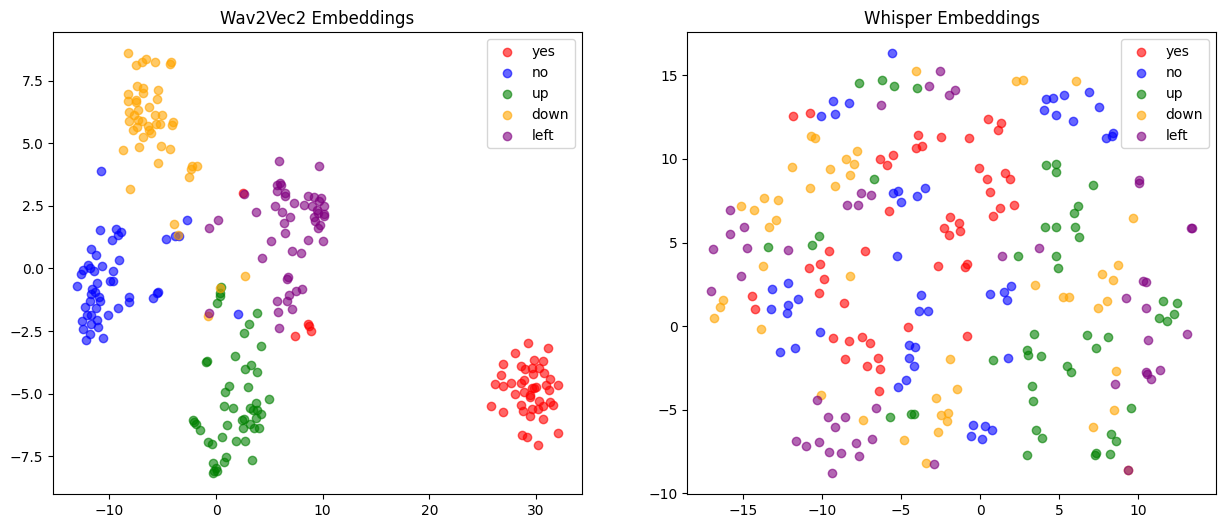

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

wav2vec_embeddings = np.array(wav2vec_embeddings)
whisper_embeddings = np.array(whisper_embeddings)

# t-SNE for Wav2Vec
wav2vec_tsne = TSNE(n_components=2, random_state=42,metric='cosine',max_iter=10000,n_iter_without_progress=1000)
wav2vec_2d = wav2vec_tsne.fit_transform(wav2vec_embeddings)

# t-SNE for Whisper  
whisper_tsne = TSNE(n_components=2, random_state=42,metric='cosine',max_iter=10000,n_iter_without_progress=1000)
whisper_2d = whisper_tsne.fit_transform(whisper_embeddings)

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Color map for words
colors = {'yes': 'red', 'no': 'blue', 'up': 'green', 'down': 'orange', 'left': 'purple'}

# Plot Wav2Vec
for word in test_words:
    mask = [l == word for l in labels]
    ax1.scatter(wav2vec_2d[mask, 0], wav2vec_2d[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax1.set_title('Wav2Vec2 Embeddings')
ax1.legend()

# Plot Whisper
for word in test_words:
    mask = [l == word for l in labels]
    ax2.scatter(whisper_2d[mask, 0], whisper_2d[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax2.set_title('Whisper Embeddings')
ax2.legend()

plt.show()

Wav2Vec PCA variance explained: 62.15%
Whisper PCA variance explained: 43.02%


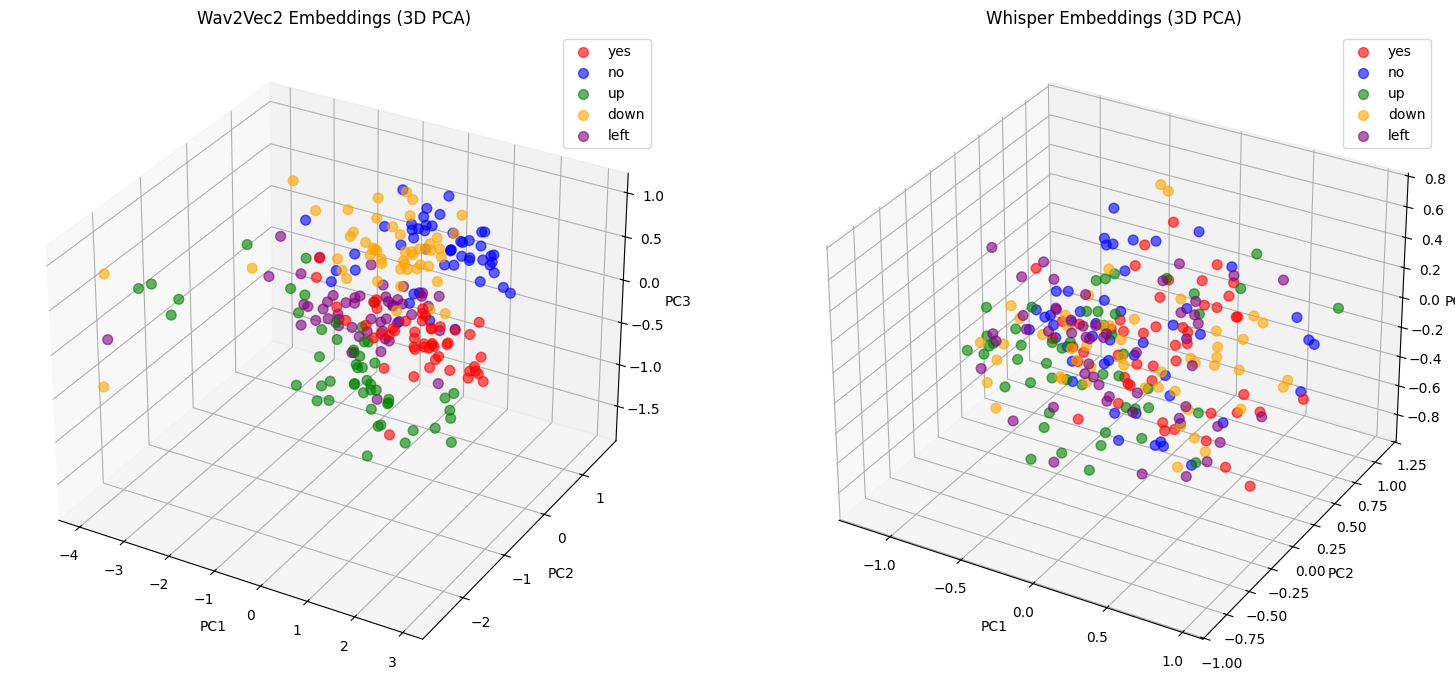

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

wav2vec_embeddings = np.array(wav2vec_embeddings)
whisper_embeddings = np.array(whisper_embeddings)

# PCA for Wav2Vec with 3 components
wav2vec_pca = PCA(n_components=3, random_state=42)
wav2vec_3d = wav2vec_pca.fit_transform(wav2vec_embeddings)

# PCA for Whisper with 3 components
whisper_pca = PCA(n_components=3, random_state=42)
whisper_3d = whisper_pca.fit_transform(whisper_embeddings)

# Print variance explained
print(f"Wav2Vec PCA variance explained: {wav2vec_pca.explained_variance_ratio_.sum():.2%}")
print(f"Whisper PCA variance explained: {whisper_pca.explained_variance_ratio_.sum():.2%}")

# Create 3D visualizations
fig = plt.figure(figsize=(16, 7))

# Color map for words
colors = {'yes': 'red', 'no': 'blue', 'up': 'green', 'down': 'orange', 'left': 'purple'}

# 3D Plot for Wav2Vec
ax1 = fig.add_subplot(121, projection='3d')
for word in test_words:
    mask = [l == word for l in labels]
    ax1.scatter(wav2vec_3d[mask, 0], wav2vec_3d[mask, 1], wav2vec_3d[mask, 2],
                label=word, color=colors[word], alpha=0.6, s=50)
ax1.set_title('Wav2Vec2 Embeddings (3D PCA)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend()

# 3D Plot for Whisper
ax2 = fig.add_subplot(122, projection='3d')
for word in test_words:
    mask = [l == word for l in labels]
    ax2.scatter(whisper_3d[mask, 0], whisper_3d[mask, 1], whisper_3d[mask, 2],
                label=word, color=colors[word], alpha=0.6, s=50)
ax2.set_title('Whisper Embeddings (3D PCA)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()

plt.tight_layout()
plt.show()

# You can also rotate the view for better perspective
# ax1.view_init(elev=20, azim=45)  # Adjust elevation and azimuth angles

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
import numpy as np

wav2vec_embeddings = np.array(wav2vec_embeddings)
whisper_embeddings = np.array(whisper_embeddings)

# PCA for both models with 3 components
wav2vec_pca = PCA(n_components=3, random_state=42)
wav2vec_3d = wav2vec_pca.fit_transform(wav2vec_embeddings)

whisper_pca = PCA(n_components=3, random_state=42)
whisper_3d = whisper_pca.fit_transform(whisper_embeddings)

# Print variance explained
print(f"Wav2Vec PCA variance explained: {wav2vec_pca.explained_variance_ratio_.sum():.2%}")
print(f"Whisper PCA variance explained: {whisper_pca.explained_variance_ratio_.sum():.2%}")

# Color map
colors = {'yes': 'red', 'no': 'blue', 'up': 'green', 'down': 'orange', 'left': 'purple'}

# Create subplots with 3D scatter
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('Wav2Vec2 Embeddings (3D PCA)', 'Whisper Embeddings (3D PCA)')
)

# Add Wav2Vec traces
for word in test_words:
    mask = [l == word for l in labels]
    fig.add_trace(
        go.Scatter3d(
            x=wav2vec_3d[mask, 0],
            y=wav2vec_3d[mask, 1],
            z=wav2vec_3d[mask, 2],
            mode='markers',
            name=word,
            marker=dict(size=5, color=colors[word], opacity=0.7),
            showlegend=True,
            legendgroup=word
        ),
        row=1, col=1
    )

# Add Whisper traces
for word in test_words:
    mask = [l == word for l in labels]
    fig.add_trace(
        go.Scatter3d(
            x=whisper_3d[mask, 0],
            y=whisper_3d[mask, 1],
            z=whisper_3d[mask, 2],
            mode='markers',
            name=word,
            marker=dict(size=5, color=colors[word], opacity=0.7),
            showlegend=False,  # Avoid duplicate legend
            legendgroup=word
        ),
        row=1, col=2
    )

# Update layout
fig.update_layout(
    height=600,
    width=1400,
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    scene2=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

fig.show()

Wav2Vec PCA variance explained: 62.15%
Whisper PCA variance explained: 43.02%


In [14]:
wav2vec_embeddings.shape

(250, 768)

In [15]:
whisper_embeddings.shape

(250, 1280)

In [16]:
TSNE?


Init signature:
TSNE(
    n_components=2,
    *,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
    max_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='euclidean',
    metric_params=None,
    init='pca',
    verbose=0,
    random_state=None,
    method='barnes_hut',
    angle=0.5,
    n_jobs=None,
)
Docstring:     
T-distributed Stochastic Neighbor Embedding.

t-SNE [1] is a tool to visualize high-dimensional data. It converts
similarities between data points to joint probabilities and tries
to minimize the Kullback-Leibler divergence between the joint
probabilities of the low-dimensional embedding and the
high-dimensional data. t-SNE has a cost function that is not convex,
i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction
method (e.g. PCA for dense data or TruncatedSVD for sparse data)
to reduce the number of dimensions to a reasonable amount 

In [19]:
wav2vec_models = [
    "facebook/wav2vec2-base",          # Pre-trained only (95M)
    "facebook/wav2vec2-base-960h",     # Fine-tuned on LibriSpeech English (95M)
    "facebook/wav2vec2-large",         # Pre-trained only (315M)
    "facebook/wav2vec2-large-960h",    # Fine-tuned on LibriSpeech English (315M)
    "facebook/wav2vec2-large-960h-lv60", # + pseudo-labeled English data (315M)
    "facebook/wav2vec2-large-960h-lv60-self", # Self-training English (315M)
]

In [20]:

whisper_models = [
    # Multilingual versions
    "openai/whisper-tiny",              # 39M params
    "openai/whisper-base",              # 74M params
    "openai/whisper-small",             # 244M params
    "openai/whisper-medium",            # 769M params
    "openai/whisper-large",             # 1550M params
    "openai/whisper-large-v2",          # 1550M params (improved)
    "openai/whisper-large-v3",          # 1550M params (latest)
    
    # English-only versions (faster, more accurate for English)
    "openai/whisper-tiny.en",           # 39M params - English only
    "openai/whisper-base.en",           # 74M params - English only
    "openai/whisper-small.en",          # 244M params - English only
    "openai/whisper-medium.en",         # 769M params - English only
]

In [21]:
speech_commands_words = [
    # Digits (10)
    "zero", "one", "two", "three", "four", 
    "five", "six", "seven", "eight", "nine",
    
    # Core commands (10)
    "yes", "no", "up", "down", "left", 
    "right", "on", "off", "stop", "go",
    
    # Additional commands (4)
    "backward", "forward", "follow", "learn",
    
    # Auxiliary words (11)
    "bed", "bird", "cat", "dog", "happy", 
    "house", "marvin", "sheila", "tree", "wow", "visual"
]

In [33]:
# Install and import DAC
import sys
sys.path.append('/home/amanag/videoEra/sound/wav2vec_vs_whisper/descript-audio-codec')
import dac
from audiotools import AudioSignal

In [34]:
# Load DAC model
model_path = dac.utils.download(model_type="16khz")  # Using 16khz to match our dataset
dac_model = dac.DAC.load(model_path)
dac_model.eval()
print(f"DAC model loaded: {model_path}")

/home/amanag/videoEra/sound/wav2vec_vs_whisper/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning:

`torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.



DAC model loaded: /home/amanag/.cache/descript/dac/weights_16khz_8kbps_0.0.5.pth


In [44]:
# Update extract_embeddings to include DAC and use 10th position vector
def extract_embeddings_all(audio_path):
    """Extract embeddings from all three models using 10th position vector"""
    audio, sr = librosa.load(audio_path, sr=16000)
    
    # Wav2Vec - use 10th position
    inputs = wa2vec_processor(audio, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        outputs = wa2vec_model(**inputs)
        # Extract vector at position 10 instead of mean
        # if outputs.last_hidden_state.shape[1] > 10:
        wav2vec_emb = outputs.last_hidden_state[:, 10, :].squeeze().numpy()
        # else:
        #     wav2vec_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    
    # Whisper - use 10th position
    inputs = whisper_processor(audio, sampling_rate=16000, return_tensors="pt")
    with torch.no_grad():
        outputs = whisper_model.encoder(**inputs)
        # Extract vector at position 10 instead of mean
        # if outputs.last_hidden_state.shape[1] > 10:
        whisper_emb = outputs.last_hidden_state[:, 10, :].squeeze().numpy()
        # else:
        #     whisper_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    
    # DAC - use 10th position
    signal = AudioSignal(audio_path)
    signal = signal.resample(16000)
    with torch.no_grad():
        audio_tensor = signal.audio_data
        audio_tensor = dac_model.preprocess(audio_tensor, 16000)
        z, codes, latents, _, _ = dac_model.encode(audio_tensor)
        # Extract 1024-dim vector at position 10
        # if z.shape[-1] > 10:
        dac_emb = z[:, :, 10].squeeze().numpy()
        # else:
        #     dac_emb = z.mean(dim=-1).squeeze().numpy()
    
    return wav2vec_emb, whisper_emb, dac_emb

In [ ]:
from joblib import Parallel, delayed

# Use 4 workers for parallel processing
n_jobs = 4
print(f"Using {n_jobs} workers for parallel processing")

# Collect all file paths first
file_paths = []
file_labels = []

for word in test_words:
    word_dir = os.path.join(dataset_path, word)
    files = os.listdir(word_dir)[:50]  # Just 50 samples per word
    
    for file in files:
        if file.endswith('.wav'):
            path = os.path.join(word_dir, file)
            file_paths.append(path)
            file_labels.append(word)

print(f"Total files to process: {len(file_paths)}")

# Parallel extraction with progress bar (4 workers)
results = Parallel(n_jobs=4)(
    delayed(extract_embeddings_all)(path) 
    for path in tqdm(file_paths, desc="Extracting embeddings")
)

# Unpack results
wav2vec_embeddings_new = []
whisper_embeddings_new = []
dac_embeddings = []

for wav2vec_emb, whisper_emb, dac_emb in results:
    wav2vec_embeddings_new.append(wav2vec_emb)
    whisper_embeddings_new.append(whisper_emb)
    dac_embeddings.append(dac_emb)

labels_new = file_labels

print(f"Extracted {len(wav2vec_embeddings_new)} Wav2Vec embeddings")
print(f"Extracted {len(whisper_embeddings_new)} Whisper embeddings")
print(f"Extracted {len(dac_embeddings)} DAC embeddings")

Processing words:  20%|██        | 1/5 [01:31<06:06, 91.64s/it]

In [ ]:
# Convert to numpy arrays
wav2vec_embeddings_new = np.array(wav2vec_embeddings_new)
whisper_embeddings_new = np.array(whisper_embeddings_new)
dac_embeddings = np.array(dac_embeddings)

print(f"Wav2Vec embeddings shape: {wav2vec_embeddings_new.shape}")
print(f"Whisper embeddings shape: {whisper_embeddings_new.shape}")
print(f"DAC embeddings shape: {dac_embeddings.shape}")

In [ ]:
# t-SNE visualization for all three models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE for all three models
wav2vec_tsne = TSNE(n_components=2, random_state=42, metric='cosine', max_iter=10000, n_iter_without_progress=1000)
wav2vec_2d_new = wav2vec_tsne.fit_transform(wav2vec_embeddings_new)

whisper_tsne = TSNE(n_components=2, random_state=42, metric='cosine', max_iter=10000, n_iter_without_progress=1000)
whisper_2d_new = whisper_tsne.fit_transform(whisper_embeddings_new)

dac_tsne = TSNE(n_components=2, random_state=42, metric='cosine', max_iter=10000, n_iter_without_progress=1000)
dac_2d = dac_tsne.fit_transform(dac_embeddings)

# Create visualizations with all three models
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Color map for words
colors = {'yes': 'red', 'no': 'blue', 'up': 'green', 'down': 'orange', 'left': 'purple'}

# Plot Wav2Vec
for word in test_words:
    mask = [l == word for l in labels_new]
    ax1.scatter(wav2vec_2d_new[mask, 0], wav2vec_2d_new[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax1.set_title('Wav2Vec2 Embeddings (t-SNE, 10th position)')
ax1.legend()

# Plot Whisper
for word in test_words:
    mask = [l == word for l in labels_new]
    ax2.scatter(whisper_2d_new[mask, 0], whisper_2d_new[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax2.set_title('Whisper Embeddings (t-SNE, 10th position)')
ax2.legend()

# Plot DAC
for word in test_words:
    mask = [l == word for l in labels_new]
    ax3.scatter(dac_2d[mask, 0], dac_2d[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax3.set_title('DAC Embeddings (t-SNE, 10th position)')
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 3D PCA visualization for all three models
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA for all three models with 3 components
wav2vec_pca_new = PCA(n_components=3, random_state=42)
wav2vec_3d_new = wav2vec_pca_new.fit_transform(wav2vec_embeddings_new)

whisper_pca_new = PCA(n_components=3, random_state=42)
whisper_3d_new = whisper_pca_new.fit_transform(whisper_embeddings_new)

dac_pca = PCA(n_components=3, random_state=42)
dac_3d = dac_pca.fit_transform(dac_embeddings)

# Print variance explained for all models
print(f"Wav2Vec PCA variance explained: {wav2vec_pca_new.explained_variance_ratio_.sum():.2%}")
print(f"Whisper PCA variance explained: {whisper_pca_new.explained_variance_ratio_.sum():.2%}")
print(f"DAC PCA variance explained: {dac_pca.explained_variance_ratio_.sum():.2%}")

# Create 3D visualizations
fig = plt.figure(figsize=(20, 6))

# Color map for words
colors = {'yes': 'red', 'no': 'blue', 'up': 'green', 'down': 'orange', 'left': 'purple'}

# 3D Plot for Wav2Vec
ax1 = fig.add_subplot(131, projection='3d')
for word in test_words:
    mask = [l == word for l in labels_new]
    ax1.scatter(wav2vec_3d_new[mask, 0], wav2vec_3d_new[mask, 1], wav2vec_3d_new[mask, 2],
                label=word, color=colors[word], alpha=0.6, s=50)
ax1.set_title('Wav2Vec2 Embeddings (3D PCA, 10th position)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend()

# 3D Plot for Whisper
ax2 = fig.add_subplot(132, projection='3d')
for word in test_words:
    mask = [l == word for l in labels_new]
    ax2.scatter(whisper_3d_new[mask, 0], whisper_3d_new[mask, 1], whisper_3d_new[mask, 2],
                label=word, color=colors[word], alpha=0.6, s=50)
ax2.set_title('Whisper Embeddings (3D PCA, 10th position)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()

# 3D Plot for DAC
ax3 = fig.add_subplot(133, projection='3d')
for word in test_words:
    mask = [l == word for l in labels_new]
    ax3.scatter(dac_3d[mask, 0], dac_3d[mask, 1], dac_3d[mask, 2],
                label=word, color=colors[word], alpha=0.6, s=50)
ax3.set_title('DAC Embeddings (3D PCA, 10th position)')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Interactive 3D visualization with Plotly (all three models)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 3D scatter
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('Wav2Vec2 (3D PCA, 10th pos)', 'Whisper (3D PCA, 10th pos)', 'DAC (3D PCA, 10th pos)')
)

# Add Wav2Vec traces
for word in test_words:
    mask = [l == word for l in labels_new]
    fig.add_trace(
        go.Scatter3d(
            x=wav2vec_3d_new[mask, 0],
            y=wav2vec_3d_new[mask, 1],
            z=wav2vec_3d_new[mask, 2],
            mode='markers',
            name=word,
            marker=dict(size=5, color=colors[word], opacity=0.7),
            showlegend=True,
            legendgroup=word
        ),
        row=1, col=1
    )

# Add Whisper traces
for word in test_words:
    mask = [l == word for l in labels_new]
    fig.add_trace(
        go.Scatter3d(
            x=whisper_3d_new[mask, 0],
            y=whisper_3d_new[mask, 1],
            z=whisper_3d_new[mask, 2],
            mode='markers',
            name=word,
            marker=dict(size=5, color=colors[word], opacity=0.7),
            showlegend=False,
            legendgroup=word
        ),
        row=1, col=2
    )

# Add DAC traces
for word in test_words:
    mask = [l == word for l in labels_new]
    fig.add_trace(
        go.Scatter3d(
            x=dac_3d[mask, 0],
            y=dac_3d[mask, 1],
            z=dac_3d[mask, 2],
            mode='markers',
            name=word,
            marker=dict(size=5, color=colors[word], opacity=0.7),
            showlegend=False,
            legendgroup=word
        ),
        row=1, col=3
    )

# Update layout
fig.update_layout(
    height=600,
    width=1800,
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    scene2=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    scene3=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

fig.show()

Extracting CNN features (transformer inputs)...


Wav2Vec CNN features shape: (250, 512)
Whisper CNN features shape: (250, 1280)


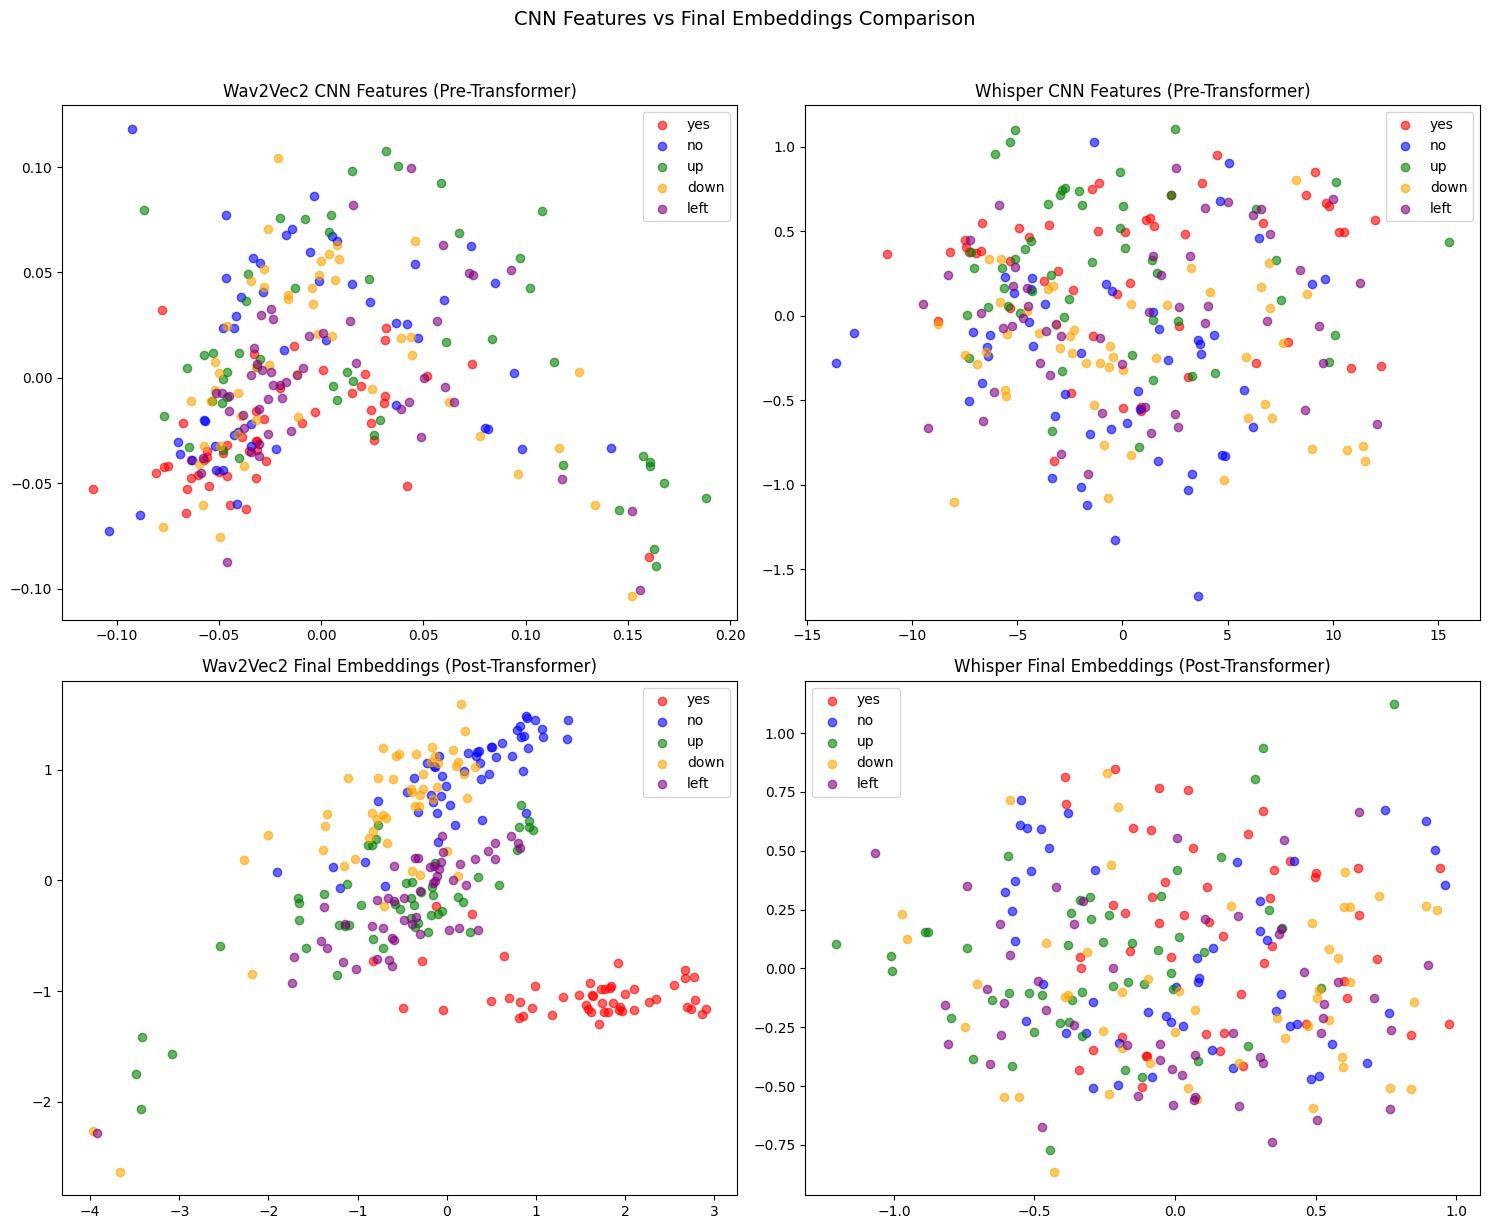


Variance explained by 2 PCs:
Wav2Vec CNN: 34.52%
Whisper CNN: 99.82%
Wav2Vec Final: 54.94%
Whisper Final: 34.65%


In [28]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa
import os

def extract_cnn_features(audio_path, model_type='wav2vec'):
    """Extract CNN features (transformer input) from audio"""
    audio, sr = librosa.load(audio_path, sr=16000)
    
    if model_type == 'wav2vec':
        inputs = wa2vec_processor(audio, sampling_rate=16000, return_tensors="pt")  # Fixed: wa2vec_processor
        with torch.no_grad():
            # Get CNN features (before transformer)
            extract_features = wa2vec_model.feature_extractor(inputs.input_values)  # Fixed: wa2vec_model
            features = extract_features.transpose(1, 2)  # Shape: (batch, time, features)
            # Average pool across time dimension
            features = features.mean(dim=1).squeeze().numpy()
            
    elif model_type == 'whisper':
        inputs = whisper_processor(audio, sampling_rate=16000, return_tensors="pt")
        with torch.no_grad():
            # Get mel spectrogram
            mel = inputs.input_features
            # Pass through conv layers (before transformer)
            conv1 = whisper_model.encoder.conv1(mel)
            conv2 = whisper_model.encoder.conv2(conv1)
            # Reshape and add positional embeddings
            features = conv2.permute(0, 2, 1)  # Shape: (batch, time, features)
            # Average pool across time dimension
            features = features.mean(dim=1).squeeze().numpy()
    
    return features

# Extract CNN features for all samples
wav2vec_cnn_features = []
whisper_cnn_features = []
labels_cnn = []

print("Extracting CNN features (transformer inputs)...")
for word in test_words:
    word_dir = os.path.join(dataset_path, word)
    files = os.listdir(word_dir)[:50]
    
    for file in files:
        if file.endswith('.wav'):
            path = os.path.join(word_dir, file)
            
            wav2vec_feat = extract_cnn_features(path, 'wav2vec')
            whisper_feat = extract_cnn_features(path, 'whisper')
            
            wav2vec_cnn_features.append(wav2vec_feat)
            whisper_cnn_features.append(whisper_feat)
            labels_cnn.append(word)

# Convert to numpy arrays
wav2vec_cnn_features = np.array(wav2vec_cnn_features)
whisper_cnn_features = np.array(whisper_cnn_features)

print(f"Wav2Vec CNN features shape: {wav2vec_cnn_features.shape}")
print(f"Whisper CNN features shape: {whisper_cnn_features.shape}")

# Apply PCA for visualization
wav2vec_cnn_pca = PCA(n_components=2, random_state=42)
wav2vec_cnn_2d = wav2vec_cnn_pca.fit_transform(wav2vec_cnn_features)

whisper_cnn_pca = PCA(n_components=2, random_state=42)
whisper_cnn_2d = whisper_cnn_pca.fit_transform(whisper_cnn_features)

# Visualize
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

colors = {'yes': 'red', 'no': 'blue', 'up': 'green', 'down': 'orange', 'left': 'purple'}

# Plot Wav2Vec CNN features
for word in test_words:
    mask = [l == word for l in labels_cnn]
    ax1.scatter(wav2vec_cnn_2d[mask, 0], wav2vec_cnn_2d[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax1.set_title('Wav2Vec2 CNN Features (Pre-Transformer)')
ax1.legend()

# Plot Whisper CNN features
for word in test_words:
    mask = [l == word for l in labels_cnn]
    ax2.scatter(whisper_cnn_2d[mask, 0], whisper_cnn_2d[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax2.set_title('Whisper CNN Features (Pre-Transformer)')
ax2.legend()

# Plot final embeddings for comparison
wav2vec_pca_final = PCA(n_components=2, random_state=42)
wav2vec_final_2d = wav2vec_pca_final.fit_transform(wav2vec_embeddings)

whisper_pca_final = PCA(n_components=2, random_state=42)
whisper_final_2d = whisper_pca_final.fit_transform(whisper_embeddings)

for word in test_words:
    mask = [l == word for l in labels]
    ax3.scatter(wav2vec_final_2d[mask, 0], wav2vec_final_2d[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax3.set_title('Wav2Vec2 Final Embeddings (Post-Transformer)')
ax3.legend()

for word in test_words:
    mask = [l == word for l in labels]
    ax4.scatter(whisper_final_2d[mask, 0], whisper_final_2d[mask, 1], 
                label=word, color=colors[word], alpha=0.6)
ax4.set_title('Whisper Final Embeddings (Post-Transformer)')
ax4.legend()

plt.suptitle('CNN Features vs Final Embeddings Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print variance explained
print(f"\nVariance explained by 2 PCs:")
print(f"Wav2Vec CNN: {wav2vec_cnn_pca.explained_variance_ratio_.sum():.2%}")
print(f"Whisper CNN: {whisper_cnn_pca.explained_variance_ratio_.sum():.2%}")
print(f"Wav2Vec Final: {wav2vec_pca_final.explained_variance_ratio_.sum():.2%}")
print(f"Whisper Final: {whisper_pca_final.explained_variance_ratio_.sum():.2%}")

In [30]:
# Transformer block details only

print("="*80)
print("TRANSFORMER ARCHITECTURE COMPARISON")
print("="*80)

# Wav2Vec2 Transformer Details
print("\n--- WAV2VEC2 TRANSFORMER ENCODER ---")
print(f"Number of layers: {len(wa2vec_model.encoder.layers)}")
print(f"Hidden size: {wa2vec_model.config.hidden_size}")
print(f"Number of attention heads: {wa2vec_model.config.num_attention_heads}")
print(f"Intermediate size (FFN): {wa2vec_model.config.intermediate_size}")
print(f"Hidden dropout: {wa2vec_model.config.hidden_dropout}")
print(f"Attention dropout: {wa2vec_model.config.attention_dropout}")

# Show one transformer layer structure
print("\nSample Transformer Layer Structure:")
print(wa2vec_model.encoder.layers[0])

# Whisper Transformer Details
print("\n" + "="*80)
print("\n--- WHISPER TRANSFORMER ENCODER ---")
print(f"Number of layers: {len(whisper_model.encoder.layers)}")
print(f"Hidden size: {whisper_model.config.d_model}")
print(f"Number of attention heads: {whisper_model.config.encoder_attention_heads}")
print(f"FFN dimension: {whisper_model.config.encoder_ffn_dim}")
print(f"Dropout: {whisper_model.config.dropout}")
print(f"Attention dropout: {whisper_model.config.attention_dropout}")

# Show one transformer layer structure
print("\nSample Transformer Layer Structure:")
print(whisper_model.encoder.layers[0])

# Quick comparison table
print("\n" + "="*80)
print("SIDE-BY-SIDE COMPARISON")
print("="*80)
print(f"{'Property':<30} | {'Wav2Vec2':<20} | {'Whisper':<20}")
print("-"*75)
print(f"{'Transformer Layers':<30} | {len(wa2vec_model.encoder.layers):<20} | {len(whisper_model.encoder.layers):<20}")
print(f"{'Hidden Dimension':<30} | {wa2vec_model.config.hidden_size:<20} | {whisper_model.config.d_model:<20}")
print(f"{'Attention Heads':<30} | {wa2vec_model.config.num_attention_heads:<20} | {whisper_model.config.encoder_attention_heads:<20}")
print(f"{'FFN Dimension':<30} | {wa2vec_model.config.intermediate_size:<20} | {whisper_model.config.encoder_ffn_dim:<20}")
print(f"{'Head Dimension':<30} | {wa2vec_model.config.hidden_size // wa2vec_model.config.num_attention_heads:<20} | {whisper_model.config.d_model // whisper_model.config.encoder_attention_heads:<20}")

TRANSFORMER ARCHITECTURE COMPARISON

--- WAV2VEC2 TRANSFORMER ENCODER ---
Number of layers: 12
Hidden size: 768
Number of attention heads: 12
Intermediate size (FFN): 3072
Hidden dropout: 0.1
Attention dropout: 0.1

Sample Transformer Layer Structure:
Wav2Vec2EncoderLayer(
  (attention): Wav2Vec2Attention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (feed_forward): Wav2Vec2FeedForward(
    (intermediate_dropout): Dropout(p=0.1, inplace=False)
    (intermediate_dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
    (output_dense): Linear(in_features=3072, out_features=768, bias=True)
    (outpu